In [25]:
from sklearn.datasets import fetch_california_housing
import pandas as pd
import matplotlib.pyplot as plt

# 下载并加载数据，指定数据存储目录为 'data'
housing = fetch_california_housing(data_home='data')

# 打印数据集的详细描述信息
print(housing.DESCR)

# 打印特征矩阵的形状 (行数, 列数)
print(housing.data.shape)

# 打印目标向量（房价）的形状
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

In [26]:
from sklearn.model_selection import train_test_split

# 1. 第一次划分：把数据分为 "训练集+验证集" (train_all) 和 "测试集" (test)
# random_state 是随机种子，确保每次运行代码时的划分结果一致
x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state=7
)

# 2. 第二次划分：把 "训练集+验证集" 进一步拆分为 "最终训练集" (train) 和 "验证集" (valid)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state=11
)

# 打印各数据集的形状，确认划分后的数据量
print("训练集形状:", x_train.shape, y_train.shape)
print("验证集形状:", x_valid.shape, y_valid.shape)
print("测试集形状:", x_test.shape, y_test.shape)

# 创建一个字典，方便后续统一调用不同数据集（这也是图中最后一部分代码的意图）
dataset_maps = {
    "train": [x_train, y_train],
    "valid": [x_valid, y_valid],
    "test":  [x_test, y_test]
}

训练集形状: (11610, 8) (11610,)
验证集形状: (3870, 8) (3870,)
测试集形状: (5160, 8) (5160,)


In [27]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader

# 初始化标准化器
scaler = StandardScaler()

# 关键步骤：只在【训练集】上计算均值和方差
scaler.fit(x_train)

,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True


In [28]:
from torch.utils.data import Dataset
import torch

class HousingDataset(Dataset):
    def __init__(self, mode='train'):
        # 1. 根据 mode (train/valid/test) 从之前定义的字典中获取对应的数据
        self.x, self.y = dataset_maps[mode]

        # 2. 特征数据处理：
        #    - scaler.transform(self.x): 使用之前 fit 好的 scaler 进行标准化
        #    - torch.from_numpy(...): 转换为 PyTorch Tensor
        #    - .float(): 转换为 float32 数据类型（神经网络的标准类型）
        self.x = torch.from_numpy(scaler.transform(self.x)).float()

        # 3. 标签数据处理：
        #    - .reshape(-1, 1): 将形状从 (N,) 变成 (N, 1)，变成二维矩阵
        self.y = torch.from_numpy(self.y).float().reshape(-1, 1)

    def __len__(self):
        # 返回数据集的大小
        return len(self.x)

    def __getitem__(self, idx):
        # 根据索引 idx 返回一条数据 (特征, 标签)
        return self.x[idx], self.y[idx]

# 实例化三个数据集对象
train_ds = HousingDataset("train")
valid_ds = HousingDataset("valid")
test_ds = HousingDataset("test")

In [29]:
from torch.utils.data import DataLoader

# 定义批次大小
# 批次大小是一个超参数：
# - 太大会导致内存（或显存）溢出
# - 太小会导致计算效率低，训练时间变长
batch_size = 8

# 创建训练集加载器
# shuffle=True 非常重要：打乱数据顺序，防止模型“死记硬背”数据的顺序，增加训练的随机性
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 创建验证集加载器
# shuffle=False：验证时我们只需要评估模型，不需要打乱顺序
val_loader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

# 创建测试集加载器
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [30]:
import torch
import torch.nn as nn

# 回归模型我们只需要输出 1 个数值（房价）
class WideDeep(nn.Module):
    def __init__(self, input_dim=8):
        super().__init__()

        # 1. 定义 "Deep" (深层) 部分
        # 这是一个包含两个隐藏层的全连接网络，用于提取非线性特征
        self.deep = nn.Sequential(
            nn.Linear(input_dim, 30), # 30个神经元
            nn.ReLU(),                # 激活函数
            nn.Linear(30, 30),        # 30个神经元
            nn.ReLU()
        )

        # 2. 定义输出层
        # PyTorch 需要自行计算输入输出维度
        # 输入维度 = Deep部分的输出 (30) + Wide部分的原始输入 (input_dim)
        self.output_layer = nn.Linear(30 + input_dim, 1)

        # 3. 初始化权重
        self.init_weights()

    def init_weights(self):
        """使用 Xavier 均匀分布来初始化全连接层的权重 W"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # x.shape: [batch_size, 8]

        # 1. 计算 Deep 部分的输出
        deep_output = self.deep(x)
        # deep_output.shape: [batch_size, 30]

        # 2. 关键步骤：拼接 (Concatenation)
        # 将原始输入 x (Wide) 与 Deep输出拼接在一起
        # dim=1 表示在特征维度上拼接 (8 + 30 = 38)
        concat = torch.cat([x, deep_output], dim=1)

        # 3. 通过输出层
        logits = self.output_layer(concat)
        # logits.shape: [batch_size, 1]

        return logits

# 实例化模型
model = WideDeep(input_dim=8)

In [31]:
# 1. 获取一条数据作为测试输入
# train_ds[0][0] 取出的是特征向量 (形状是 [8])
# .reshape(1, -1) 将其变成 (形状 [1, 8])，增加由 Batch Size 组成的维度
input = train_ds[0][0].reshape(1, -1)

print(input.shape)
# 输出: torch.Size([1, 8])

# 2. 实例化模型
model = WideDeep()

# 3. 将数据喂给模型 (前向传播)
out = model(input)

# 4. 检查输出形状
out.shape
# 预期输出: torch.Size([1, 1]) -> 1个样本，1个预测值

torch.Size([1, 8])


torch.Size([1, 1])

In [32]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = -1
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


In [33]:
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm.auto import tqdm

# 定义 device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for datas, labels in dataloader:
        datas = datas.to(device)
        labels = labels.to(device)
        # 前向计算
        logits = model(datas)
        loss = loss_fct(logits, labels)         # 验证集损失
        loss_list.append(loss.item())

    return np.mean(loss_list)


In [34]:
# 训练
def training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=None,
    early_stop_callback=None,
    eval_step=500,
    ):
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 0
    model.train()
    with tqdm(total=epoch * len(train_loader)) as pbar:
        for epoch_id in range(epoch):
            # training
            for datas, labels in train_loader:
                datas = datas.to(device)
                labels = labels.to(device)
                # 梯度清空
                optimizer.zero_grad()
                # 模型前向计算
                logits = model(datas)
                # 计算损失
                loss = loss_fct(logits, labels)
                # 梯度回传
                loss.backward()
                # 调整优化器，包括学习率的变动等
                optimizer.step()

                loss = loss.cpu().item()
                # record

                record_dict["train"].append({
                    "loss": loss, "step": global_step
                })

                # evaluating
                if global_step % eval_step == 0:
                    model.eval()
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()

                    # 早停 Early Stop
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # udate step
                global_step += 1
                pbar.update(1)
                pbar.set_postfix({"epoch": epoch_id})

    return record_dict


epoch = 10

model = WideDeep()

# 1. 定义损失函数 采用交叉熵损失
loss_fct = nn.MSELoss()
# 2. 定义优化器 采用SGD
# Optimizers specified in the torch.optim package
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.0)

# 3. early stop
early_stop_callback = EarlyStopCallback(patience=10, min_delta=1e-3)

model = model.to(device)
record = training(
    model,
    train_loader,
    val_loader,
    epoch,
    loss_fct,
    optimizer,
    early_stop_callback=early_stop_callback,
    eval_step=len(train_loader)
    )

  0%|          | 0/14520 [00:00<?, ?it/s]

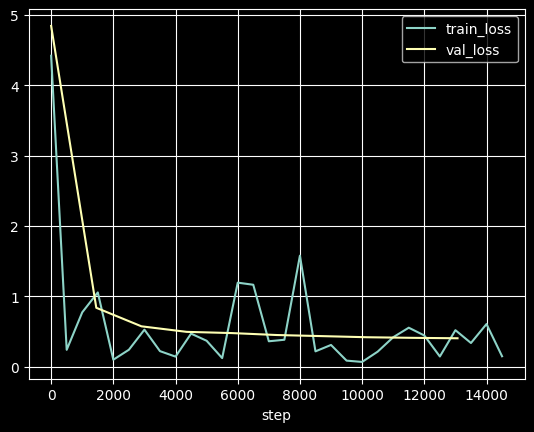

In [35]:
#画线要注意的是损失是不一定在零到1之间的
def plot_learning_curves(record_dict, sample_step=500):
    # build DataFrame
    train_df = pd.DataFrame(record_dict["train"]).set_index("step").iloc[::sample_step]
    val_df = pd.DataFrame(record_dict["val"]).set_index("step")

    # plot
    for idx, item in enumerate(train_df.columns):
        plt.plot(train_df.index, train_df[item], label=f"train_{item}")
        plt.plot(val_df.index, val_df[item], label=f"val_{item}")
        plt.grid()
        plt.legend()
        # plt.xticks(range(0, train_df.index[-1], 10*sample_step), range(0, train_df.index[-1], 10*sample_step))
        plt.xlabel("step")

        plt.show()

plot_learning_curves(record, sample_step=500)  #横坐标是 steps

In [36]:
model.eval()
loss = evaluating(model, val_loader, loss_fct)
print(f"loss:     {loss:.4f}")

loss:     0.3989
